# Part-of-speech Tagging Using RNNs

Some initialization:

In [4]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cpu
random seed: 1234


Next, let's read the words and their POS tags from the CoNLLUP format:

In [5]:
from conllu import parse_incr

def read_tags(filename):
    data = {'words': [], 'tags': []}
    with open(filename) as f:
        for sent in parse_incr(f):
            words = [tok['form'] for tok in sent]
            tags = [tok['upos'] for tok in sent]
            data['words'].append(words)
            data['tags'].append(tags)
    return pd.DataFrame(data)

In [6]:
train_df = read_tags('data/UD_Spanish-AnCora/es_ancora-ud-train.conllup')
train_df

,words,tags
0,"[El, presidente, de, el, órgano, regulador, de...","[DET, NOUN, ADP, DET, NOUN, ADJ, ADP, DET, PRO..."
1,"[Sobre, la, oferta, de, interconexión, con, Te...","[ADP, DET, NOUN, ADP, NOUN, ADP, PROPN, ADP, D..."
2,"[Afirmó, que, sigue, el, criterio, europeo, y,...","[VERB, SCONJ, VERB, DET, NOUN, ADJ, CCONJ, SCO..."
3,"[La, inversión, en, investigación, básica, es,...","[DET, NOUN, ADP, NOUN, ADJ, AUX, DET, NOUN, AD..."
4,"[Durante, la, presentación, de, el, libro, "", ...","[ADP, DET, NOUN, ADP, DET, NOUN, PUNCT, DET, P..."
...,...,...
14300,"[Y, todas, las, miradas, convergen, en, la, lu...","[CCONJ, DET, DET, NOUN, VERB, ADP, DET, NOUN, ..."
14301,"[Conviene, que, ahora, ,, en, plena, apoteosis...","[VERB, SCONJ, ADV, PUNCT, ADP, ADJ, NOUN, ADP,..."
14302,"[Cambiar, las, formas, parece, de, rigor, ,, p...","[VERB, DET, NOUN, VERB, ADP, NOUN, PUNCT, CCON..."
14303,"[Carlos, y, Fayna, se, enzarzan, en, una, bron...","[PROPN, CCONJ, PROPN, PRON, VERB, ADP, DET, NO..."


We now load the GloVe embeddings for Spanish, which include a representation for the unknown token:

In [7]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format('glove-sbwc.i25.vec')
glove.vectors.shape

(855380, 300)

In [8]:
# these embeddings already include <unk>
unk_tok = '<unk>'
unk_id = glove.key_to_index[unk_tok]
unk_tok, unk_id

('<unk>', 855379)

In [9]:
# add padding embedding
pad_tok = '<pad>'
pad_emb = np.zeros(300)
glove.add_vector(pad_tok, pad_emb)
pad_tok_id = glove.key_to_index[pad_tok]
pad_tok, pad_tok_id

/Users/msurdeanu/miniconda3/envs/transformers/lib/python3.10/site-packages/gensim/models/keyedvectors.py:478: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


('<pad>', 855380)

Preprocessing: lower case all words, and replace all numbers with '0':

In [10]:
def preprocess(words):
    result = []
    for w in words:
        w = w.lower()
        if w.isdecimal():
            w = '0'
        result.append(w)
    return result

train_df['words'] = train_df['words'].progress_map(preprocess)
train_df

  0%|          | 0/14305 [00:00<?, ?it/s]

,words,tags
0,"[el, presidente, de, el, órgano, regulador, de...","[DET, NOUN, ADP, DET, NOUN, ADJ, ADP, DET, PRO..."
1,"[sobre, la, oferta, de, interconexión, con, te...","[ADP, DET, NOUN, ADP, NOUN, ADP, PROPN, ADP, D..."
2,"[afirmó, que, sigue, el, criterio, europeo, y,...","[VERB, SCONJ, VERB, DET, NOUN, ADJ, CCONJ, SCO..."
3,"[la, inversión, en, investigación, básica, es,...","[DET, NOUN, ADP, NOUN, ADJ, AUX, DET, NOUN, AD..."
4,"[durante, la, presentación, de, el, libro, "", ...","[ADP, DET, NOUN, ADP, DET, NOUN, PUNCT, DET, P..."
...,...,...
14300,"[y, todas, las, miradas, convergen, en, la, lu...","[CCONJ, DET, DET, NOUN, VERB, ADP, DET, NOUN, ..."
14301,"[conviene, que, ahora, ,, en, plena, apoteosis...","[VERB, SCONJ, ADV, PUNCT, ADP, ADJ, NOUN, ADP,..."
14302,"[cambiar, las, formas, parece, de, rigor, ,, p...","[VERB, DET, NOUN, VERB, ADP, NOUN, PUNCT, CCON..."
14303,"[carlos, y, fayna, se, enzarzan, en, una, bron...","[PROPN, CCONJ, PROPN, PRON, VERB, ADP, DET, NO..."


Next, construct actual PyTorch `Dataset` and `DataLoader` objects for the train/dev/test partitions:

In [11]:
def get_ids(tokens, key_to_index, unk_id=None):
    return [key_to_index.get(tok, unk_id) for tok in tokens]

def get_word_ids(tokens):
    return get_ids(tokens, glove.key_to_index, unk_id)

# add new column to the dataframe
train_df['word ids'] = train_df['words'].progress_map(get_word_ids)
train_df

  0%|          | 0/14305 [00:00<?, ?it/s]

,words,tags,word ids
0,"[el, presidente, de, el, órgano, regulador, de...","[DET, NOUN, ADP, DET, NOUN, ADJ, ADP, DET, PRO...","[2, 74, 0, 2, 1690, 9398, 0, 10, 3841, 11, 229..."
1,"[sobre, la, oferta, de, interconexión, con, te...","[ADP, DET, NOUN, ADP, NOUN, ADP, PROPN, ADP, D...","[26, 1, 1680, 0, 15163, 14, 3541, 0, 60, 4803,..."
2,"[afirmó, que, sigue, el, criterio, europeo, y,...","[VERB, SCONJ, VERB, DET, NOUN, ADJ, CCONJ, SCO...","[1066, 5, 490, 2, 3014, 448, 4, 5, 371, 0, 156..."
3,"[la, inversión, en, investigación, básica, es,...","[DET, NOUN, ADP, NOUN, ADJ, AUX, DET, NOUN, AD...","[1, 1039, 3, 349, 2983, 20, 2, 854, 15, 2, 631..."
4,"[durante, la, presentación, de, el, libro, "", ...","[ADP, DET, NOUN, ADP, DET, NOUN, PUNCT, DET, P...","[52, 1, 818, 0, 2, 751, 855379, 1, 6279, 12, 1..."
...,...,...,...
14300,"[y, todas, las, miradas, convergen, en, la, lu...","[CCONJ, DET, DET, NOUN, VERB, ADP, DET, NOUN, ...","[4, 128, 10, 14402, 28137, 3, 1, 89711, 0, 1, ..."
14301,"[conviene, que, ahora, ,, en, plena, apoteosis...","[VERB, SCONJ, ADV, PUNCT, ADP, ADJ, NOUN, ADP,...","[4198, 5, 172, 855379, 3, 1767, 48622, 0, 8553..."
14302,"[cambiar, las, formas, parece, de, rigor, ,, p...","[VERB, DET, NOUN, VERB, ADP, NOUN, PUNCT, CCON...","[1858, 10, 741, 711, 0, 8155, 855379, 32, 8553..."
14303,"[carlos, y, fayna, se, enzarzan, en, una, bron...","[PROPN, CCONJ, PROPN, PRON, VERB, ADP, DET, NO...","[509, 4, 220484, 11, 136570, 3, 16, 28730, 120..."


In [12]:
pad_tag = '<pad>'
index_to_tag = train_df['tags'].explode().unique().tolist() + [pad_tag]
tag_to_index = {t:i for i,t in enumerate(index_to_tag)}
pad_tag_id = tag_to_index[pad_tag]
pad_tag, pad_tag_id

('<pad>', 17)

In [13]:
index_to_tag

['DET',
 'NOUN',
 'ADP',
 'ADJ',
 'PROPN',
 'PRON',
 'VERB',
 'SCONJ',
 'PUNCT',
 'AUX',
 'CCONJ',
 'ADV',
 'NUM',
 'PART',
 'SYM',
 'INTJ',
 'X',
 '<pad>']

In [14]:
def get_tag_ids(tags):
    return get_ids(tags, tag_to_index)

train_df['tag ids'] = train_df['tags'].progress_map(get_tag_ids)
train_df

  0%|          | 0/14305 [00:00<?, ?it/s]

,words,tags,word ids,tag ids
0,"[el, presidente, de, el, órgano, regulador, de...","[DET, NOUN, ADP, DET, NOUN, ADJ, ADP, DET, PRO...","[2, 74, 0, 2, 1690, 9398, 0, 10, 3841, 11, 229...","[0, 1, 2, 0, 1, 3, 2, 0, 4, 5, 6, 3, 2, 6, 0, ..."
1,"[sobre, la, oferta, de, interconexión, con, te...","[ADP, DET, NOUN, ADP, NOUN, ADP, PROPN, ADP, D...","[26, 1, 1680, 0, 15163, 14, 3541, 0, 60, 4803,...","[2, 0, 1, 2, 1, 2, 4, 2, 0, 1, 5, 6, 2, 6, 0, ..."
2,"[afirmó, que, sigue, el, criterio, europeo, y,...","[VERB, SCONJ, VERB, DET, NOUN, ADJ, CCONJ, SCO...","[1066, 5, 490, 2, 3014, 448, 4, 5, 371, 0, 156...","[6, 7, 6, 0, 1, 3, 10, 7, 6, 2, 6, 0, 1, 5, 11..."
3,"[la, inversión, en, investigación, básica, es,...","[DET, NOUN, ADP, NOUN, ADJ, AUX, DET, NOUN, AD...","[1, 1039, 3, 349, 2983, 20, 2, 854, 15, 2, 631...","[0, 1, 2, 1, 3, 9, 0, 1, 2, 0, 1, 10, 0, 1, 3,..."
4,"[durante, la, presentación, de, el, libro, "", ...","[ADP, DET, NOUN, ADP, DET, NOUN, PUNCT, DET, P...","[52, 1, 818, 0, 2, 751, 855379, 1, 6279, 12, 1...","[2, 0, 1, 2, 0, 1, 8, 0, 4, 2, 4, 2, 0, 4, 8, ..."
...,...,...,...,...
14300,"[y, todas, las, miradas, convergen, en, la, lu...","[CCONJ, DET, DET, NOUN, VERB, ADP, DET, NOUN, ...","[4, 128, 10, 14402, 28137, 3, 1, 89711, 0, 1, ...","[10, 0, 0, 1, 6, 2, 0, 1, 2, 0, 4, 7, 2, 11, 6..."
14301,"[conviene, que, ahora, ,, en, plena, apoteosis...","[VERB, SCONJ, ADV, PUNCT, ADP, ADJ, NOUN, ADP,...","[4198, 5, 172, 855379, 3, 1767, 48622, 0, 8553...","[6, 7, 11, 8, 2, 3, 1, 2, 1, 8, 6, 0, 4, 4, 11..."
14302,"[cambiar, las, formas, parece, de, rigor, ,, p...","[VERB, DET, NOUN, VERB, ADP, NOUN, PUNCT, CCON...","[1858, 10, 741, 711, 0, 8155, 855379, 32, 8553...","[6, 0, 1, 6, 2, 1, 8, 10, 8, 2, 0, 1, 8, 0, 1,..."
14303,"[carlos, y, fayna, se, enzarzan, en, una, bron...","[PROPN, CCONJ, PROPN, PRON, VERB, ADP, DET, NO...","[509, 4, 220484, 11, 136570, 3, 16, 28730, 120...","[4, 10, 4, 5, 6, 2, 0, 1, 2, 0, 1, 8]"


In [15]:
dev_df = read_tags('data/UD_Spanish-AnCora/es_ancora-ud-dev.conllup')
dev_df['words'] = dev_df['words'].progress_map(preprocess)
dev_df['word ids'] = dev_df['words'].progress_map(lambda x: get_ids(x, glove.key_to_index, unk_id))
dev_df['tag ids'] = dev_df['tags'].progress_map(lambda x: get_ids(x, tag_to_index))
dev_df

  0%|          | 0/1654 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

,words,tags,word ids,tag ids
0,"[el, gobernante, ,, con, ganada, fama, desde, ...","[DET, NOUN, PUNCT, ADP, ADJ, NOUN, ADP, SCONJ,...","[2, 6221, 855379, 14, 18832, 3449, 41, 5, 626,...","[0, 1, 8, 2, 3, 1, 2, 7, 6, 6, 12, 1, 2, 0, 1,..."
1,"[chávez, se, despidió, de, el, mundanal, ruido...","[PROPN, PRON, VERB, ADP, DET, ADJ, NOUN, DET, ...","[3063, 11, 14578, 0, 2, 115792, 5407, 2, 218, ...","[4, 5, 6, 2, 0, 3, 1, 0, 1, 1, 2, 0, 11, 3, 1,..."
2,"[desde, entonces, entró, en, silencio, absolut...","[ADP, ADV, VERB, ADP, NOUN, ADJ, PUNCT]","[41, 304, 2127, 3, 3323, 4133, 855379]","[2, 11, 6, 2, 1, 3, 8]"
3,"[nadie, sabe, cuál, es, la, nueva, fecha, que,...","[PRON, VERB, PRON, AUX, DET, ADJ, NOUN, PRON, ...","[1113, 1428, 2639, 20, 1, 122, 364, 5, 2022, 1...","[5, 6, 5, 9, 0, 3, 1, 5, 6, 2, 0, 1, 8, 10, 7,..."
4,"[por, su, boca, suelen, hablar, de, vez, en, c...","[ADP, DET, NOUN, VERB, VERB, ADP, NOUN, ADP, A...","[12, 17, 2779, 2591, 1489, 0, 90, 3, 51, 110, ...","[2, 0, 1, 6, 6, 2, 1, 2, 11, 11, 0, 1, 2, 4, 4..."
...,...,...,...,...
1649,"[una, visita, a, la, playa, recién, inaugurada...","[DET, NOUN, ADP, DET, NOUN, ADV, ADJ, PRON, VE...","[16, 1267, 7, 1, 2310, 2375, 7969, 175, 8674, ...","[0, 1, 2, 0, 1, 11, 3, 5, 6, 2, 7, 5, 9, 9, 0,..."
1650,"[los, pechos, femeninos, vuelven, a, estar, ta...","[DET, NOUN, ADJ, VERB, ADP, AUX, ADJ, PUNCT]","[8, 25159, 12704, 6475, 7, 413, 59662, 855379]","[0, 1, 3, 6, 2, 9, 3, 8]"
1651,"[¿, será, que, el, tabú, de, el, seno, materno...","[PUNCT, AUX, SCONJ, DET, NOUN, ADP, DET, NOUN,...","[855379, 226, 5, 2, 23730, 0, 2, 3543, 14347, ...","[8, 9, 7, 0, 1, 2, 0, 1, 3, 9, 11, 3, 2, 6, 5,..."
1652,"[¿, o, que, los, varones, mirábamos, con, dema...","[PUNCT, CCONJ, SCONJ, DET, NOUN, VERB, ADP, DE...","[855379, 24, 5, 8, 5327, 125769, 14, 11912, 56...","[8, 10, 7, 0, 1, 6, 2, 0, 1, 8, 8]"


In [16]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x[index])
        y = torch.tensor(self.y[index])
        return x, y

`collate_fn` will be used by `DataLoader` to pad all sentences in the same batch to the same length.

In [17]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # separate xs and ys
    xs, ys = zip(*batch)
    # get lengths
    lengths = [len(x) for x in xs]
    # pad sequences
    x_padded = pad_sequence(xs, batch_first=True, padding_value=pad_tok_id)
    y_padded = pad_sequence(ys, batch_first=True, padding_value=pad_tag_id)
    # return padded
    return x_padded, y_padded, lengths

Now construct our PyTorch model:

In [18]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MyModel(nn.Module):
    def __init__(self, vectors, hidden_size, num_layers, bidirectional, dropout, output_size):
        super().__init__()
        # ensure vectors is a tensor
        if not torch.is_tensor(vectors):
            vectors = torch.tensor(vectors)
        # init embedding layer
        self.embedding = nn.Embedding.from_pretrained(embeddings=vectors)
        # init lstm
        self.lstm = nn.LSTM(
            input_size=vectors.shape[1],
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True)
        # init dropout
        self.dropout = nn.Dropout(dropout)
        # init classifier
        self.classifier = nn.Linear(
            in_features=hidden_size * 2 if bidirectional else hidden_size,
            out_features=output_size)
        
    def forward(self, x_padded, x_lengths):
        # get embeddings
        output = self.embedding(x_padded)
        output = self.dropout(output)
        # pack data before lstm
        packed = pack_padded_sequence(output, x_lengths, batch_first=True, enforce_sorted=False)
        packed, _ = self.lstm(packed)
        # unpack data before rest of model
        output, _ = pad_packed_sequence(packed, batch_first=True)
        output = self.dropout(output)
        output = self.classifier(output)
        return output

In [19]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# hyperparameters
lr = 1e-3
weight_decay = 1e-5
batch_size = 100
shuffle = True
n_epochs = 10
vectors = glove.vectors
hidden_size = 100
num_layers = 2
bidirectional = True
dropout = 0.1
output_size = len(index_to_tag)

# initialize the model, loss function, optimizer, and data-loader
model = MyModel(vectors, hidden_size, num_layers, bidirectional, dropout, output_size).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
train_ds = MyDataset(train_df['word ids'], train_df['tag ids'])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
dev_ds = MyDataset(dev_df['word ids'], dev_df['tag ids'])
dev_dl = DataLoader(dev_ds, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

train_loss, train_acc = [], []
dev_loss, dev_acc = [], []

We are now ready to train!

In [20]:
# train the model
for epoch in range(n_epochs):
    losses, acc = [], []
    model.train()
    for x_padded, y_padded, lengths in tqdm(train_dl, desc=f'epoch {epoch+1} (train)'):
        # clear gradients
        model.zero_grad()
        # send batch to right device
        x_padded = x_padded.to(device)
        y_padded = y_padded.to(device)
        # predict label scores
        y_pred = model(x_padded, lengths)
        # reshape output
        y_true = torch.flatten(y_padded)
        y_pred = y_pred.view(-1, output_size)
        mask = y_true != pad_tag_id
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        # compute loss
        loss = loss_func(y_pred, y_true)
        # accumulate for plotting
        gold = y_true.detach().cpu().numpy()
        pred = np.argmax(y_pred.detach().cpu().numpy(), axis=1)
        losses.append(loss.detach().cpu().item())
        acc.append(accuracy_score(gold, pred))
        # backpropagate
        loss.backward()
        # optimize model parameters
        optimizer.step()
    train_loss.append(np.mean(losses))
    train_acc.append(np.mean(acc))
    
    model.eval()
    with torch.no_grad():
        losses, acc = [], []
        for x_padded, y_padded, lengths in tqdm(dev_dl, desc=f'epoch {epoch+1} (dev)'):
            x_padded = x_padded.to(device)
            y_padded = y_padded.to(device)
            y_pred = model(x_padded, lengths)
            y_true = torch.flatten(y_padded)
            y_pred = y_pred.view(-1, output_size)
            mask = y_true != pad_tag_id
            y_true = y_true[mask]
            y_pred = y_pred[mask]
            loss = loss_func(y_pred, y_true)
            gold = y_true.cpu().numpy()
            pred = np.argmax(y_pred.cpu().numpy(), axis=1)
            losses.append(loss.cpu().item())
            acc.append(accuracy_score(gold, pred))
        dev_loss.append(np.mean(losses))
        dev_acc.append(np.mean(acc))

epoch 1 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 1 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

epoch 2 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 2 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

epoch 3 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 3 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

epoch 4 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 4 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

epoch 5 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 5 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

epoch 6 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 6 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

epoch 7 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 7 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

epoch 8 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 8 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

epoch 9 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 9 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

epoch 10 (train):   0%|          | 0/144 [00:00<?, ?it/s]

epoch 10 (dev):   0%|          | 0/17 [00:00<?, ?it/s]

Plot loss and accuracy on dev after each epoch:

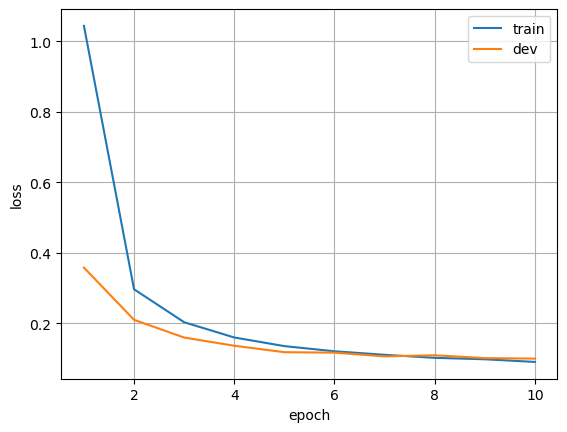

In [21]:
import matplotlib.pyplot as plt

x = np.arange(n_epochs) + 1

plt.plot(x, train_loss)
plt.plot(x, dev_loss)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)

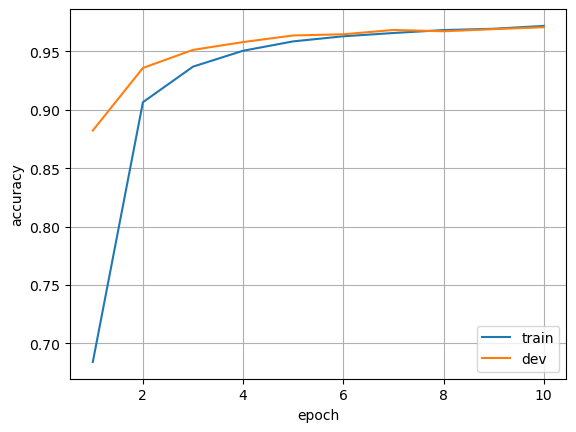

In [22]:
plt.plot(x, train_acc)
plt.plot(x, dev_acc)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)

In [23]:
test_df = read_tags('data/UD_Spanish-AnCora/es_ancora-ud-test.conllup')
test_df['words'] = test_df['words'].progress_map(preprocess)
test_df['word ids'] = test_df['words'].progress_map(lambda x: get_ids(x, glove.key_to_index, unk_id))
test_df['tag ids'] = test_df['tags'].progress_map(lambda x: get_ids(x, tag_to_index))
test_df

  0%|          | 0/1721 [00:00<?, ?it/s]

  0%|          | 0/1721 [00:00<?, ?it/s]

  0%|          | 0/1721 [00:00<?, ?it/s]

,words,tags,word ids,tag ids
0,"[partidario, de, la, "", perestroika, "", de, mi...","[ADJ, ADP, DET, PUNCT, NOUN, PUNCT, ADP, PROPN...","[8983, 0, 1, 855379, 54911, 855379, 0, 41295, ...","[3, 2, 0, 8, 1, 8, 2, 4, 4, 2, 0, 4, 4, 8, 2, ..."
1,"[días, después, ,, el, 0, de, noviembre, de, 0...","[NOUN, ADV, PUNCT, DET, NUM, ADP, NOUN, ADP, N...","[204, 78, 855379, 2, 6, 0, 330, 0, 6, 855379, ...","[1, 11, 8, 0, 12, 2, 1, 2, 12, 8, 6, 3, 2, 0, ..."
2,"[después, de, el, triunfo, electoral, de, los,...","[ADV, ADP, DET, NOUN, ADJ, ADP, DET, NOUN, PUN...","[78, 0, 2, 2150, 922, 0, 8, 2879, 855379, 485,...","[11, 2, 0, 1, 3, 2, 0, 1, 8, 3, 1, 8, 2, 0, 3,..."
3,"[descontento, por, la, falta, de, apoyo, de, e...","[ADJ, ADP, DET, NOUN, ADP, NOUN, ADP, DET, PRO...","[10482, 12, 1, 435, 0, 167, 0, 2, 168, 1671, 1...","[3, 2, 0, 1, 2, 1, 2, 0, 4, 4, 4, 8, 4, 8, 3, ..."
4,"[el, ministerio, chino, de, asuntos, exteriore...","[DET, PROPN, ADJ, ADP, PROPN, PROPN, VERB, ADV...","[2, 481, 2863, 0, 498, 1374, 5789, 170, 2, 531...","[0, 4, 3, 2, 4, 4, 6, 11, 0, 1, 2, 0, 1, 3, 3,..."
...,...,...,...,...
1716,"[gómez-angulo, también, quiso, ser, contundent...","[PROPN, ADV, VERB, AUX, ADJ, ADP, DET, NOUN, A...","[855379, 31, 3544, 45, 8834, 3, 1, 6566, 0, 2,...","[4, 11, 6, 9, 3, 2, 0, 1, 2, 0, 1, 8]"
1717,"["", es, un, borrón, en, la, historia, de, el, ...","[PUNCT, AUX, DET, NOUN, ADP, DET, NOUN, ADP, D...","[855379, 20, 13, 51985, 3, 1, 276, 0, 2, 2246,...","[8, 9, 0, 1, 2, 0, 1, 2, 0, 1, 3, 8, 8, 6, 8]"
1718,"[reiteró, ,, también, ,, que, se, iban, a, end...","[VERB, PUNCT, ADV, PUNCT, SCONJ, PRON, AUX, AD...","[4285, 855379, 31, 855379, 5, 11, 3660, 7, 290...","[6, 8, 11, 8, 7, 5, 9, 2, 6, 0, 1, 3, 2, 4, 8,..."
1719,"[gómez-angulo, aprovechó, la, entrevista, de, ...","[PROPN, VERB, DET, NOUN, ADP, PROPN, ADP, VERB...","[855379, 6076, 1, 1923, 0, 2558, 15, 2110, 855...","[4, 6, 0, 1, 2, 4, 2, 6, 8, 1, 8, 2, 0, 1, 4, ..."


Now let's evaluate on the test partition:

In [24]:
from sklearn.metrics import classification_report

model.eval()

test_ds = MyDataset(test_df['word ids'], test_df['tag ids'])
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for x_padded, y_padded, lengths in tqdm(test_dl):
        x_padded = x_padded.to(device)
        y_pred = model(x_padded, lengths)
        y_true = torch.flatten(y_padded)
        y_pred = y_pred.view(-1, output_size)
        mask = y_true != pad_tag_id
        y_true = y_true[mask]
        y_pred = torch.argmax(y_pred[mask], dim=1)
        all_y_true.append(y_true.cpu().numpy())
        all_y_pred.append(y_pred.cpu().numpy())

y_true = np.concatenate(all_y_true)
y_pred = np.concatenate(all_y_pred)
target_names = index_to_tag[:-2]
print(classification_report(y_true, y_pred, target_names=target_names))

  0%|          | 0/18 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         DET       0.99      1.00      0.99      8040
        NOUN       0.95      0.96      0.95      9533
         ADP       1.00      1.00      1.00      8332
         ADJ       0.92      0.93      0.92      3468
       PROPN       0.93      0.87      0.90      4101
        PRON       0.98      0.95      0.97      2484
        VERB       0.97      0.98      0.98      4544
       SCONJ       0.93      0.98      0.95      1210
       PUNCT       0.97      1.00      0.98      6314
         AUX       0.98      0.98      0.98      1396
       CCONJ       0.99      1.00      1.00      1439
         ADV       0.97      0.97      0.97      1710
         NUM       0.96      0.87      0.91       958
        PART       0.81      0.72      0.76        18
         SYM       0.75      0.32      0.45        37
        INTJ       0.82      0.56      0.67        16

    accuracy                           0.97     53600
   macro avg       0.93   

Let's generate a confusion matrix for all POS tags in the data:

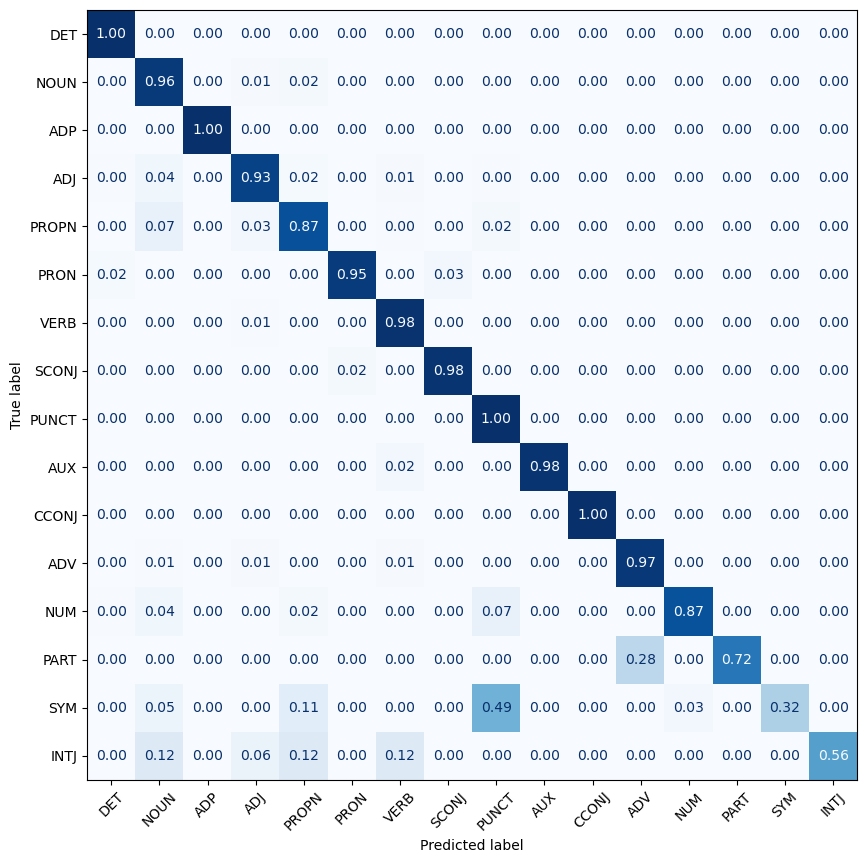

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names,
)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(
    cmap='Blues',
    values_format='.2f',
    colorbar=False,
    ax=ax,
    xticks_rotation=45,
)